In [1]:
import pickle
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from ipywidgets import *

from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

In [2]:
datapath = os.path.join(os.getcwd(), '..', 'datasets', 'co_feats32.pkl')

with open(datapath, 'rb') as f:
    data = pickle.load(f)

In [3]:
# get neural data and hand velocities
neu = data['neural']
vel = data['behavior'][:,[2,3]]

# adding time history
hist = 6
adjneu = np.zeros((neu.shape[0]-hist, 96, hist+1))
for h in range(hist+1):
    adjneu[:,:,h] = neu[h:neu.shape[0]-hist+h,:]
adjneu = adjneu.reshape(adjneu.shape[0],-1)
adjvel = vel[hist:,:]

# separate a training and test set
X_train, X_test, y_train, y_test = train_test_split(adjneu, adjvel, test_size=0.2, shuffle=False)

# train a ridge regression
ridge = Ridge(alpha=0.001)
ridge.fit(X_train, y_train)


Ridge(alpha=0.001)

In [4]:
# test the ridge regression
yhat = ridge.predict(X_test)

# show test r^2
print(f'Test R2: {ridge.score(X_test, y_test)}')

Test R2: 0.3204990321009685


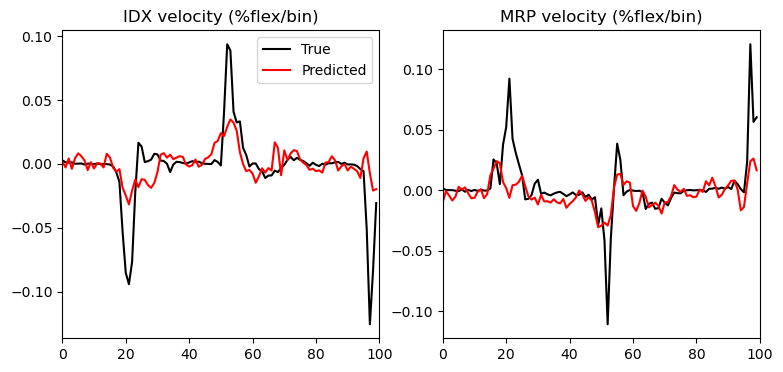

In [5]:
# plot predicted vs. true kinematics

fig, ax = plt.subplots(1,2, figsize = (9, 4))
finger = ['IDX','MRP']
for i in range(2):
    ax[i].plot(y_test[0:100,i], c='k')
    ax[i].plot(yhat[0:100,i], c='r')
    ax[i].set(xlim=(0,100),title=f'{finger[i]} velocity (%flex/bin)')
    if i == 0:
        ax[i].legend(('True', 'Predicted'))

In [6]:
"Python script that rips out highest mean SBP"

'Python script that rips out highest mean SBP'

In [7]:
import os
import pickle
import numpy as np
from scipy.signal import welch

def load_dataset(path):
    ext = os.path.splitext(path)[1].lower()
    if ext == ".pkl":
        with open(path, "rb") as f:
            return pickle.load(f)
    elif ext == ".npz":
        return dict(np.load(path, allow_pickle=True))
    else:
        raise ValueError(f"Unsupported file: {path}")

def compute_sbp(neural, fs=1000 / 3.5, band=(300, 6000)):
    freqs, psd = welch(neural, fs=fs, nperseg=min(neural.shape[0], int(fs)), axis=0)
    band_mask = (freqs >= band[0]) & (freqs <= band[1])
    sbp = np.trapz(psd[band_mask, :], freqs[band_mask], axis=0)  # integrate PSD over band
    return sbp

def rank_datasets_by_mean_sbp(folder, fs=30000, band=(300, 6000), top_k_channels=10):
    results = []
    for fname in sorted(os.listdir(folder)):
        if not fname.lower().endswith((".pkl", ".npz")):
            continue
        path = os.path.join(folder, fname)
        try:
            data = load_dataset(path)
            if "neural" not in data:
                continue
            neural = np.asarray(data["neural"])
            sbp = compute_sbp(neural, fs=fs, band=band)
            mean_sbp = float(np.mean(sbp))
            top_channels = np.argsort(sbp)[::-1][:top_k_channels]
            results.append({
                "path": path,
                "mean_sbp": mean_sbp,
                "top_channels_idx": top_channels.tolist(),
            })
        except Exception as e:
            print(f"[WARN] Skipping {path}: {e}")
    results.sort(key=lambda x: x["mean_sbp"], reverse=True)
    return results

def summarize(results, max_rows=10):
    print(f"\nDatasets ranked by mean SBP (top {min(max_rows, len(results))}):\n")
    for i, r in enumerate(results[:max_rows], 1):
        print(f"{i:2d}. {os.path.basename(r['path'])} | mean SBP: {r['mean_sbp']:.3e} | top channels: {r['top_channels_idx'][:5]}...")

# Example usage:
if __name__ == "__main__":
    # change dataset location if needed
    folder = "/home/efri-student22/hackathon-BMI/datasets"
    results = rank_datasets_by_mean_sbp(folder, fs=30000, band=(300, 1000))
    summarize(results)

    # Get the single highest-SBP dataset
    if results:
        best = results[0]
        print("\nHighest SBP datasets by mean:")
        print(" Mean SBP:", best["mean_sbp"])
        print(" Top channel indices:", best["top_channels_idx"])



Datasets ranked by mean SBP (top 8):

 1. co_feats20.pkl | mean SBP: 1.387e+00 | top channels: [32, 71, 67, 37, 70]...
 2. co_feats32.pkl | mean SBP: 1.322e+00 | top channels: [32, 67, 71, 37, 70]...
 3. r_feats20.pkl | mean SBP: 1.306e+00 | top channels: [32, 67, 71, 70, 37]...
 4. r_feats32.pkl | mean SBP: 1.166e+00 | top channels: [32, 67, 71, 70, 37]...
 5. r_feats50.pkl | mean SBP: 6.241e-01 | top channels: [71, 32, 67, 81, 70]...
 6. co_feats50.pkl | mean SBP: 5.366e-01 | top channels: [71, 67, 81, 32, 37]...
 7. r_feats100.pkl | mean SBP: 3.427e-01 | top channels: [71, 81, 67, 32, 37]...
 8. co_feats100.pkl | mean SBP: 2.707e-01 | top channels: [71, 81, 67, 32, 37]...

Highest SBP datasets by mean:
 Mean SBP: 1.3866507753758943
 Top channel indices: [32, 71, 67, 37, 70, 81, 89, 64, 2, 72]


In [8]:
"Taking into account binned data :)"

'Taking into account binned data :)'

In [9]:
import os, re, pickle, numpy as np
from scipy.signal import welch

# ---- config ----
FOLDER = "/home/efri-student22/hackathon-BMI/datasets"  # adjust if needed
TOP_K_CHANNELS = 10

def infer_fs_and_band(filename: str):
    """Infer effective fs and suitable band from bin size in ms."""
    m = re.search(r'(\d+)', filename)
    bin_ms = float(m.group(1)) if m else 32.0
    fs = 1000.0 / bin_ms
    band = (0.1, max(0.1, 0.9 * fs / 2.0))
    return fs, band

def load_dataset(path: str):
    ext = os.path.splitext(path)[1].lower()
    if ext == ".pkl":
        with open(path, "rb") as f:
            return pickle.load(f)
    elif ext == ".npz":
        return dict(np.load(path, allow_pickle=True))
    else:
        raise ValueError(f"Unsupported file type: {path}")

def compute_band_power(neural: np.ndarray, fs: float, band: tuple[float, float]) -> np.ndarray:
    """Compute per-channel band power using Welch PSD integration."""
    if neural.ndim != 2:
        raise ValueError(f"'neural' must be 2D (T, C); got {neural.shape}")
    T = neural.shape[0]
    nperseg = max(16, min(T, int(max(8, fs))))
    freqs, psd = welch(neural, fs=fs, nperseg=nperseg, axis=0)
    mask = (freqs >= band[0]) & (freqs <= band[1])
    if not np.any(mask):
        mask = slice(None)
    return np.trapz(psd[mask, :], freqs[mask], axis=0)

def rank_datasets_by_mean_bandpower(folder: str):
    print(f"\nScanning folder: {folder}")
    if not os.path.isdir(folder):
        print("Folder does not exist.")
        return []

    cand = [f for f in sorted(os.listdir(folder)) if f.lower().endswith((".pkl", ".npz"))]
    if not cand:
        print("No .pkl or .npz files found.")
        return []

    results = []
    for fname in cand:
        path = os.path.join(folder, fname)
        fs, band = infer_fs_and_band(fname)
        try:
            data = load_dataset(path)
            if "neural" not in data:
                print(f"[WARN] {fname}: no 'neural' key. Keys present: {list(data.keys())}")
                continue
            neural = np.asarray(data["neural"])
            bp = compute_band_power(neural, fs, band)
            mean_bp = float(np.mean(bp))
            top_idx = np.argsort(bp)[::-1][:TOP_K_CHANNELS]
            top_vals = bp[top_idx]
            results.append({
                "file": fname,
                "path": path,
                "fs": fs,
                "band": band,
                "mean_band_power": mean_bp,
                "top_channels": top_idx.tolist(),
                "top_values": top_vals.tolist()
            })
            print(f"[OK] {fname}: mean_BP={mean_bp:.3e}, fs={fs:.2f} Hz, band={band}")
        except Exception as e:
            print(f"[ERR] {fname}: {e}")

    results.sort(key=lambda x: x["mean_band_power"], reverse=True)

    print("\n---- Ranked by mean band power ----")
    for i, r in enumerate(results, 1):
        print(f"{i:2d}. {r['file']:20s}  mean_BP={r['mean_band_power']:.3e}  fs={r['fs']:.2f} Hz  band={r['band']}")
        print(f"    Top {TOP_K_CHANNELS} channels:")
        for j, (ch, val) in enumerate(zip(r['top_channels'], r['top_values']), 1):
            print(f"      {j:2d}. Channel {ch:3d}  →  {val:.3e}")
        print("")

    return results


results = rank_datasets_by_mean_bandpower(FOLDER)

if results:
    best = results[0]
    print("\n========== BEST DATASET ==========")
    print(f"File: {best['file']}")
    print(f"Mean band power: {best['mean_band_power']:.3e}")
    print(f"Sampling rate: {best['fs']:.2f} Hz")
    print(f"Band: {best['band']}")
    print("Top channels (index → mean band power):")
    for ch, val in zip(best["top_channels"], best["top_values"]):
        print(f"   Channel {ch:3d} → {val:.3e}")
    print("==================================\n")
else:
    print("No datasets processed.")





Scanning folder: /home/efri-student22/hackathon-BMI/datasets
[OK] co_feats100.pkl: mean_BP=2.041e+00, fs=10.00 Hz, band=(0.1, 4.5)
[OK] co_feats20.pkl: mean_BP=5.856e+00, fs=50.00 Hz, band=(0.1, 22.5)
[OK] co_feats32.pkl: mean_BP=3.718e+00, fs=31.25 Hz, band=(0.1, 14.0625)
[OK] co_feats50.pkl: mean_BP=2.735e+00, fs=20.00 Hz, band=(0.1, 9.0)
[OK] r_feats100.pkl: mean_BP=1.897e+00, fs=10.00 Hz, band=(0.1, 4.5)
[OK] r_feats20.pkl: mean_BP=5.723e+00, fs=50.00 Hz, band=(0.1, 22.5)
[OK] r_feats32.pkl: mean_BP=3.624e+00, fs=31.25 Hz, band=(0.1, 14.0625)
[OK] r_feats50.pkl: mean_BP=2.643e+00, fs=20.00 Hz, band=(0.1, 9.0)

---- Ranked by mean band power ----
 1. co_feats20.pkl        mean_BP=5.856e+00  fs=50.00 Hz  band=(0.1, 22.5)
    Top 10 channels:
       1. Channel  71  →  6.138e+01
       2. Channel  81  →  3.787e+01
       3. Channel  67  →  2.765e+01
       4. Channel  32  →  2.594e+01
       5. Channel  89  →  2.121e+01
       6. Channel  70  →  2.088e+01
       7. Channel  77  →  2.0

In [10]:
"Removing bottom 10 channels [58, 62, 94, 1, 11, 31, 69, 65, 51, 76]  working pile {58, 94, 31, 65,} Corrilation pile {31, 11, 69, 1, 62, 94, 65, 58, 51, 30}"

'Removing bottom 10 channels [58, 62, 94, 1, 11, 31, 69, 65, 51, 76]  working pile {58, 94, 31, 65,}'

In [45]:
# adding in exclusion
exclude = {31, 11, 69, 1, 62, 94, 65, 58, 51, 30}
C_all = data['neural'].shape[1]
keep_idx = [ch for ch in range(C_all) if ch not in exclude]

neu = data['neural'][:, keep_idx]
vel = data['behavior'][:, [2, 3]]

hist = 6
T, C = neu.shape

adjneu = np.zeros((T - hist, C, hist + 1))
for h in range(hist + 1):
    adjneu[:, :, h] = neu[h:T - hist + h, :]

adjneu = adjneu.reshape(T - hist, C * (hist + 1))
adjvel = vel[hist:, :]

print(f"Excluded {C_all - C} channels → kept {C}")
assert adjneu.shape[0] == adjvel.shape[0]

X_train, X_test, y_train, y_test = train_test_split(adjneu, adjvel, test_size=0.2, shuffle=False)

ridge = Ridge(alpha=0.001)
ridge.fit(X_train, y_train)


Excluded 10 channels → kept 86


Ridge(alpha=0.001)

In [46]:
# test the ridge regression
yhat = ridge.predict(X_test)

# show test r^2
print(f'Test R2: {ridge.score(X_test, y_test)}')

Test R2: 0.3180929633777758


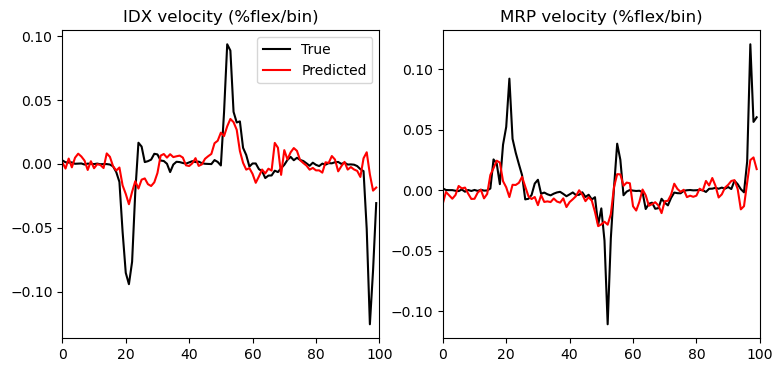

In [13]:
# plot predicted vs. true kinematics

fig, ax = plt.subplots(1,2, figsize = (9, 4))
finger = ['IDX','MRP']
for i in range(2):
    ax[i].plot(y_test[0:100,i], c='k')
    ax[i].plot(yhat[0:100,i], c='r')
    ax[i].set(xlim=(0,100),title=f'{finger[i]} velocity (%flex/bin)')
    if i == 0:
        ax[i].legend(('True', 'Predicted'))

In [14]:
"Corrilation RR Model"

'Corrilation RR Model'

In [15]:
"Throwing everything together"

'Throwing everything together'

In [16]:
# get neural data and hand velocities
neu = data['neural']
vel = data['behavior'][:,[2,3]]

# isolated channels
top_channels = [66, 2, 37, 70, 90, 39, 78, 3, 8, 64]
neu_selected = neu[:, top_channels]

# adding time history
hist = 6
T, C_sel = neu_selected.shape
adjneu = np.zeros((T - hist, C_sel, hist + 1))
for h in range(hist + 1):
    adjneu[:, :, h] = neu_selected[h:T - hist + h, :]

# flatten the time-lag dimension into features
adjneu = adjneu.reshape(T - hist, -1)

# align velocities
adjvel = vel[hist:, :]

# train/test split (no shuffle to preserve temporal order)
X_train, X_test, y_train, y_test = train_test_split(
    adjneu, adjvel, test_size=0.2, shuffle=False
)

# ridge regression
ridge = Ridge(alpha=0.001)
ridge.fit(X_train, y_train)

Ridge(alpha=0.001)

In [17]:
yhat = ridge.predict(X_test)

# show test r^2
print(f'Test R2: {ridge.score(X_test, y_test)}')

Test R2: 0.163788898880581


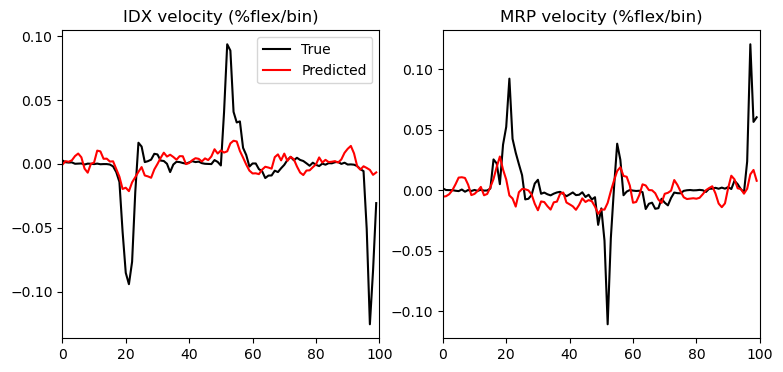

In [18]:
fig, ax = plt.subplots(1,2, figsize = (9, 4))
finger = ['IDX','MRP']
for i in range(2):
    ax[i].plot(y_test[0:100,i], c='k')
    ax[i].plot(yhat[0:100,i], c='r')
    ax[i].set(xlim=(0,100),title=f'{finger[i]} velocity (%flex/bin)')
    if i == 0:
        ax[i].legend(('True', 'Predicted'))